In [1]:
#imports
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
import dask.array as da
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
import pandas as pd
import numpy as np
import dask_ml
#prefs
pd.set_option('max_columns', None)


In [2]:
#close existing dask connection if it exists and open a new one
try:
    if client is not None:
        client.close()
        print("closed existing connection, ",client)       
except Exception as e:
    print(e)
    

name 'client' is not defined


In [3]:
#get new connection
client = Client(n_workers=2, threads_per_worker=2, memory_limit='8GB')
display(client)

Client Scheduler: tcp://127.0.0.1:39749 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 12.26 GiB


In [4]:
# train on FTP-BruteForce data
data = dd.read_csv("ids-data/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv",dtype={'Active Mean': 'float64',
       'Active Std': 'float64', 'Label': 'str'})



In [5]:
%%time

def time_cleaner(t):
    date, time = t.split()
    hour, minute, second = time.split(':')
    if int(hour) < 8:
        hour = int(hour) + 12
    
    return f'{date} {hour}:{minute}:{second}'

data['Timestamp'] = data['Timestamp'].apply(lambda x: time_cleaner(x), meta=('Timestamp', 'str'))
data['Timestamp'] = dd.to_datetime(data.Timestamp, format='%d/%m/%Y %H:%M:%S').astype(np.int64)
data['Timestamp'] = data['Timestamp'].apply(lambda x: np.int64(x / 1000000000), meta=('Timestamp', 'int64'))

max_val = np.finfo(np.float32).max
data['Flow Byts/s'] = data['Flow Byts/s'].apply(lambda x: x if x < max_val else max_val, meta=('Flow Byts/s', 'float32'))
data['Flow Pkts/s'] = data['Flow Pkts/s'].apply(lambda x: x if x < max_val else max_val, meta=('Flow Pkts/s', 'float32'))

data['Label'] = data['Label'].apply(lambda x: 0 if x == 'Benign' else 1, meta=('Label', 'int32'))

clean_data = data.persist()
display(len(clean_data))


1048575

CPU times: user 620 ms, sys: 162 ms, total: 782 ms
Wall time: 10.4 s


In [6]:
## Get the minimum time value
#first_time = clean_data.nsmallest(1, 'Timestamp')

## Get the maximum time value
#last_time = clean_data.nlargest(1, 'Timestamp')

# TODO: Have a way to specify the time window... right now it's by second
# prev_time = 0
# time_step = 1000000000
# for t in range(first_time, last_time, time_step):
#     # Get all records in the current time window
#     window = clean_data[(clean_data.Timestamp > prev_time) & (clean_data.Timestamp <= t)]

#     # Create a row that aggregates the information in each row


#     prev_time = t

# Possible features
# Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label

agg_data = clean_data.groupby(['Timestamp', 'Dst Port', 'Protocol']).agg(
    {
        'Flow Duration': ['mean'],
        'Tot Fwd Pkts': ['sum'],
        'Tot Bwd Pkts': ['sum', 'count'],
        'TotLen Fwd Pkts' : ['sum'],
        'TotLen Bwd Pkts' : ['sum'],
        'Fwd Pkt Len Max' : ['mean'],
        'Fwd Pkt Len Min' : ['mean'],
        'Fwd Pkt Len Mean' : ['mean'],
        #'Fwd PSH Flags' : ['count'],
        #'Bwd PSH Flags' : ['count'],
        #'Fwd URG Flags' : ['count'],
        #'Bwd URG Flags' : ['count'],
        'FIN Flag Cnt' : ['count'],
        'SYN Flag Cnt' : ['count'],
        'RST Flag Cnt' : ['count'],
        'PSH Flag Cnt' : ['count'],
        'ACK Flag Cnt' : ['count'],
        #'URG Flag Cnt' : ['count'],
        #'CWE Flag Count' : ['count'],
        #'ECE Flag Cnt' : ['count'],
        'Label': ['sum']
    }
)

agg_data.head()



Flow Duration Tot Fwd Pkts Tot Bwd Pkts        \
                                      mean          sum          sum count   
Timestamp  Dst Port Protocol                                                 
1518597038 9984     6           72593289.0           91           83     1   
1518597061 0        0          112641719.0            3            0     1   
1518597230 0        0           56413649.0           11            0     2   
1518597399 0        0          112638623.0            3            0     1   
1518597568 0        0          112640480.0            3            0     1   

                             TotLen Fwd Pkts TotLen Bwd Pkts Fwd Pkt Len Max  \
                                         sum             sum            mean   
Timestamp  Dst Port Protocol                                                   
1518597038 9984     6                   7680            1728           192.0   
1518597061 0        0                      0               0             0.0   
1518597230 0        0                      0               0             0.0   
1518597399 0        0                      0               0             0.0   
1518597568 0        0                      0               0             0.0   

                             Fwd Pkt Len Min Fwd Pkt Len Mean FIN Flag Cnt  \
                                        mean             mean        count   
Timestamp  Dst Port Protocol                                                 
1518597038 9984     6                   64.0        84.395604            1   
1518597061 0        0                    0.0         0.000000            1   
1518597230 0        0                    0.0         0.000000            2   
1518597399 0        0                    0.0         0.000000            1   
1518597568 0        0                    0.0         0.000000            1   

                             SYN Flag Cnt RST Flag Cnt PSH Flag Cnt  \
                                    count        count        count   
Timestamp  Dst Port Protocol                                          
1518597038 9984     6                   1            1            1   
1518597061 0        0                   1            1            1   
1518597230 0        0                   2            2            2   
1518597399 0        0                   1            1            1   
1518597568 0        0                   1            1            1   

                             ACK Flag Cnt Label  
                                    count   sum  
Timestamp  Dst Port Protocol                     
1518597038 9984     6                   1     0  
1518597061 0        0                   1     0  
1518597230 0        0                   2     0  
1518597399 0        0                   1     0  
1518597568 0        0                   1     0

In [7]:
len(agg_data[agg_data['Label']['sum'] > 0])


11268

In [8]:
agg_labels = agg_data['Label']['sum']
agg_train = agg_data.drop('Label', axis=1)

agg_train = agg_train.reset_index()
agg_train = agg_train.drop('Timestamp', axis=1)
#agg_train = agg_train.drop('Dst Port', axis=1)
#agg_train = agg_train.drop('Protocol', axis=1)
agg_train.head()



/home/mwdehn/.local/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Dst Port Protocol Flow Duration Tot Fwd Pkts Tot Bwd Pkts        \
                             mean          sum          sum count   
0     9984        6    72593289.0           91           83     1   
1        0        0   112641719.0            3            0     1   
2        0        0    56413649.0           11            0     2   
3        0        0   112638623.0            3            0     1   
4        0        0   112640480.0            3            0     1   

  TotLen Fwd Pkts TotLen Bwd Pkts Fwd Pkt Len Max Fwd Pkt Len Min  \
              sum             sum            mean            mean   
0            7680            1728           192.0            64.0   
1               0               0             0.0             0.0   
2               0               0             0.0             0.0   
3               0               0             0.0             0.0   
4               0               0             0.0             0.0   

  Fwd Pkt Len Mean FIN Flag Cnt SYN Flag Cnt RST Flag Cnt PSH Flag Cnt  \
              mean        count        count        count        count   
0        84.395604            1            1            1            1   
1         0.000000            1            1            1            1   
2         0.000000            2            2            2            2   
3         0.000000            1            1            1            1   
4         0.000000            1            1            1            1   

  ACK Flag Cnt  
         count  
0            1  
1            1  
2            2  
3            1  
4            1

In [9]:
%%time

# Fit and predict based on the FTP-BruteForce attacks
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0, max_features=0.25, contamination=0.1)

clf.fit(agg_train)#, y_train)
y_predict = clf.predict(agg_train)

CPU times: user 10.7 s, sys: 138 ms, total: 10.9 s
Wall time: 12.8 s


precision = 0.45674955595026645; recall = 0.9128505502307419; accuracy = 0.9414591795603237


22520

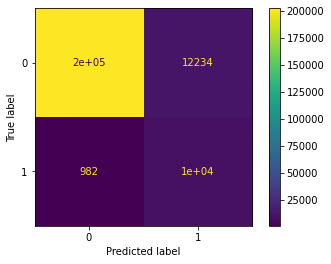

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

predicted = y_predict
actual = [1 if y == 0 else -1 for y in agg_labels]

precision = precision_score(actual, predicted, pos_label=-1)
recall = recall_score(actual, predicted, pos_label=-1)
accuracy = accuracy_score(actual, predicted)
print(f'precision = {precision}; recall = {recall}; accuracy = {accuracy}')

cm = confusion_matrix(actual, predicted, labels=[1, -1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

len([y for y in predicted if y < 0])
